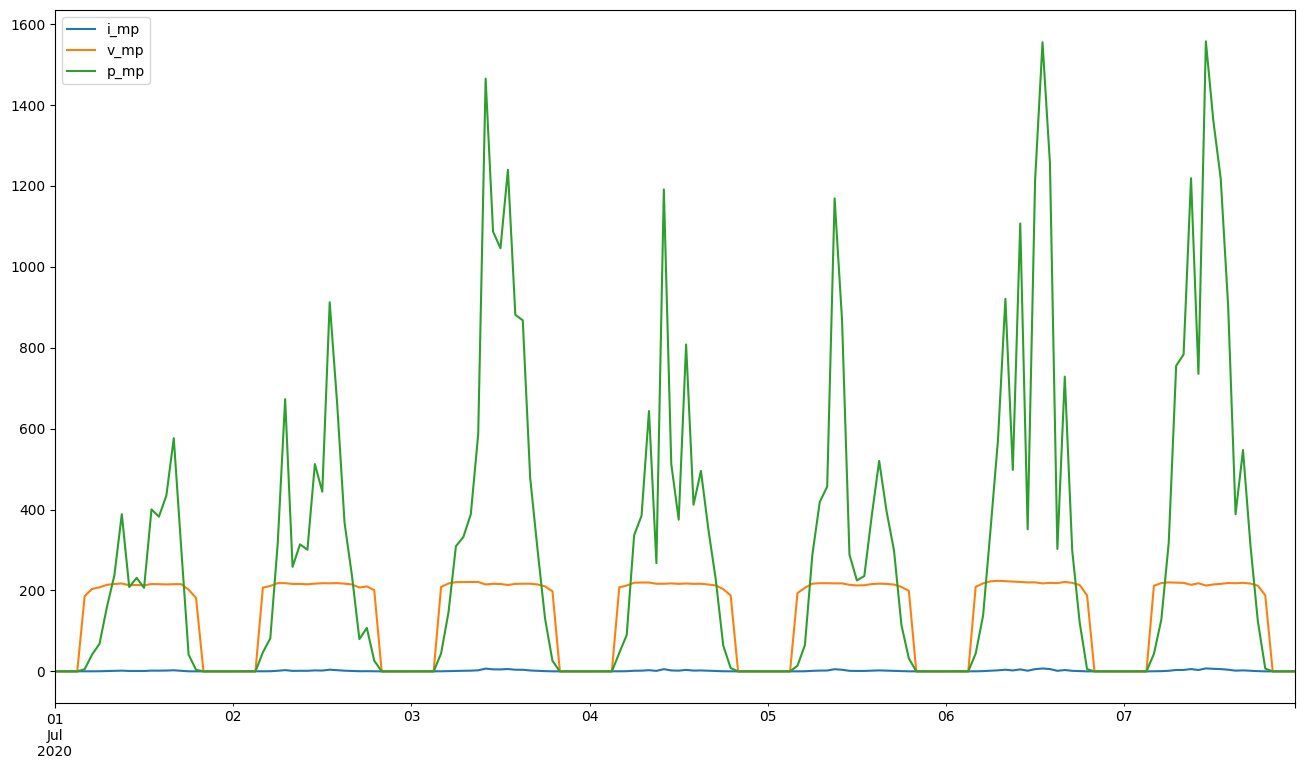

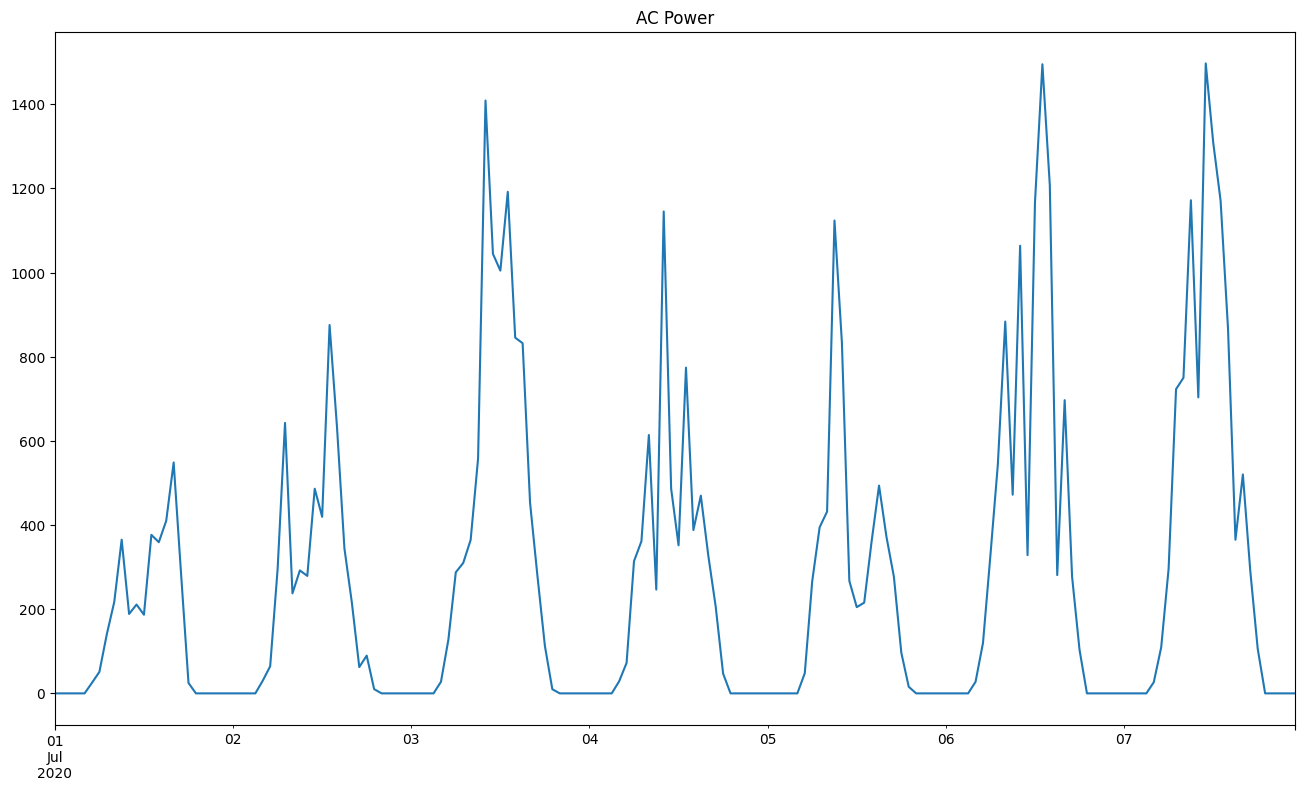

In [5]:
import pvlib
from pvlib.location import Location
from pvlib.pvsystem import PVSystem
import pandas as pd
import matplotlib.pyplot as plt

celltype ='monoSi'
pdc0 = 400,
v_mp = 44.1
i_mp = 9.08
v_oc = 53.4
i_sc = 9.60
alpha_sc = 0.0005 * i_sc
beta_voc = -0.0029 * v_oc
gamma_pdc = -0.37
cells_in_series = 6*27
temp_ref = 25

location = Location(latitude=50.941389,
                    longitude=6.958711, tz='Europe/Berlin', altitude=80,
                    name='Cologne')

surface_tilt=45
surface_azimuth=180

start="2020-07-01 00:00"
end= "2020-07-07 23:00"

poa_data_2020 = pd.read_csv("poa_data_2020.csv", index_col=0)
poa_data_2020.index = pd.date_range(start="2020-01-01 00:000",
                                  periods=len(poa_data_2020.index),
                                  freq="h")
poa_data = poa_data_2020[start:end]

solarpos = location.get_solarposition(times=pd.date_range(start=start, end=end,
                                                          freq="h"))

# Calcula o ângulo de incidência do vetor solar em uma superfície.
#Este é o ângulo entre o vetor solar e a superfície normal.
aoi = pvlib.irradiance.aoi(surface_tilt, surface_azimuth, solarpos.apparent_zenith,
                           solarpos.azimuth)

# Determina o modificador do ângulo de incidência
iam = pvlib.iam.ashrae(aoi)

# A irradiância (W/m2) que é convertida em fotocorrente.
effective_irradiance = poa_data["poa_direct"] * iam + poa_data["poa_diffuse"]

# Temperatura da celula.
temp_cell = pvlib.temperature.faiman(poa_data["poa_global"], poa_data["temp_air"],
                                     poa_data["wind_speed"])

# Estima parâmetros para o modelo de diodo único
I_L_ref, I_o_ref, R_s, R_sh_ref, a_ref, Adjust = pvlib.ivtools.sdm.fit_cec_sam(
   celltype =celltype,
   v_mp = v_mp,
   i_mp = i_mp,
   v_oc = v_oc,
   i_sc = i_sc,
   alpha_sc = alpha_sc,
   beta_voc = beta_voc,
   gamma_pmp = gamma_pdc,
   cells_in_series = cells_in_series,
   temp_ref = temp_ref)

# Calcula cinco valores de parâmetros para a equação de diodo único em irradiância efetiva e temperatura celular
cec_params = pvlib.pvsystem.calcparams_cec(effective_irradiance,
                              temp_cell,
                              alpha_sc,
                              a_ref,
                              I_L_ref,
                              I_o_ref,
                              R_sh_ref,
                              R_s,
                              Adjust)

# Dado o coeficiente da equação do diodo único, calcula-se a potência máxima ponto (MPP)
mpp = pvlib.pvsystem.max_power_point(*cec_params,
                                     method='newton')
#mpp.plot(figsize=(16,9))
#plt.show()

system = PVSystem(modules_per_string=5, strings_per_inverter=1)

# Dimensiona a tensão, a corrente e a potência
dc_scaled = system.scale_voltage_current_power(mpp)

dc_scaled.plot(figsize=(16,9))
plt.show()

cec_inverters = pvlib.pvsystem.retrieve_sam('CECInverter')
inverter = cec_inverters['ABB__PVI_3_0_OUTD_S_US__208V_']

ac_results = pvlib.inverter.sandia(v_dc=dc_scaled.v_mp,
                                   p_dc=dc_scaled.p_mp,
                                   inverter=inverter)
# Alimentação AC
ac_results.plot(figsize=(16,9))
plt.title("AC Power")
plt.show()